In [ ]:
!git clone https://github.com/facebookresearch/dinov2 --quiet
!pip install -r ./dinov2/requirements.txt --quiet
!pip install -e ./dinov2 --quiet

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for dinov2 (pyproject.toml) ... done


In [ ]:
# imports
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "drive/MyDrive/DINOv2_with_Minecraft_GUI"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/DINOv2_with_Minecraft_GUI'
/content/drive/MyDrive/DINOv2_with_Minecraft_GUI


In [ ]:
# pre trained models
models = {
    "dinov2_vits14": {
        "model": lambda : torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14'),
        "feat_dim": 384
    },
    "dinov2_vitb14": {
        "model": lambda : torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14'),
        "feat_dim": 768
    },
    "dinov2_vitl14": {
        "model": lambda : torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14'),
        "feat_dim": 1024
    },
    "dinov2_vitg14": {
        "model": lambda : torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14'),
        "feat_dim": 1536
    }
}

In [ ]:
# parameters
img_path = "crafting_menu.png"
model_name = "dinov2_vits14"
if not torch.cuda.is_available():
  raise Exception("DINOv2 needs cuda to function properly")
device = torch.device("cuda:0")
model = models[model_name]["model"]().to(device)
feat_dim = models[model_name]["feat_dim"]

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [ ]:
# load and transform image
img = Image.open(img_path).convert('RGB')
new_height = img.height - img.height % 14
new_width = img.width - img.width % 14
transform = T.Compose([
    T.Resize((new_height, new_width)),
    T.ToTensor(),
])
img_transformed = transform(img)
patch_h = int(new_height/14)
patch_w = int(new_width/14)
imgs_tensor = torch.zeros(1, 3, img_transformed.shape[1], img_transformed.shape[2]).to(device)
imgs_tensor[0] = img_transformed

In [ ]:
# run model
with torch.no_grad():
    features_dict = model.forward_features(imgs_tensor)
    features = features_dict['x_norm_patchtokens']
features = features.reshape(patch_h * patch_w, feat_dim).cpu()
pca = PCA(n_components=3)
pca.fit(features)
pca_features = pca.transform(features)

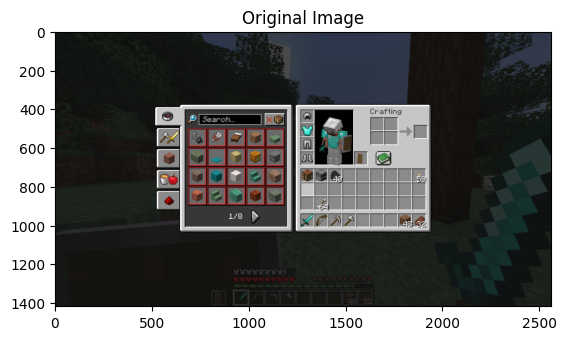

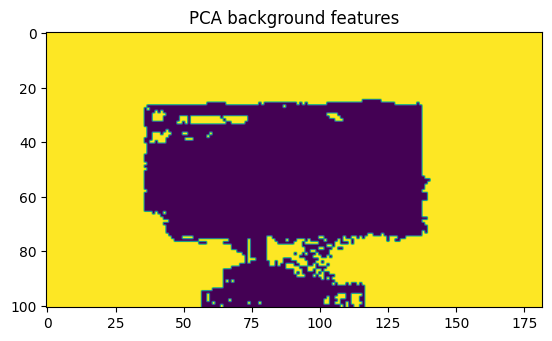

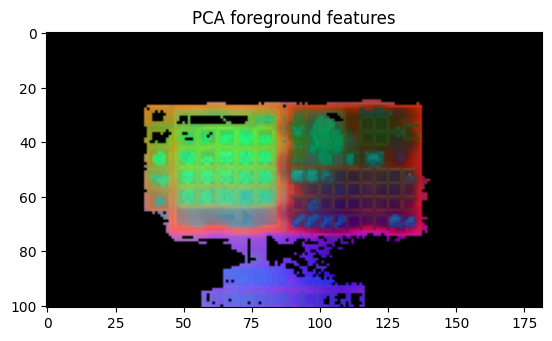

In [ ]:
# source: https://github.com/facebookresearch/dinov2/issues/23#issuecomment-1515483746
# visualize PCA components for finding a proper threshold
'''
fig, axs = plt.subplots(1, 3)
for i, ax in enumerate(axs):
  ax.hist(pca_features[:, i])
fig.suptitle("PCA components")
plt.show()
'''

# segment using the first component
threshold = 7.5
pca_features_bg = pca_features[:, 0] < threshold
pca_features_fg = ~pca_features_bg

# plot the original
plt.imshow(img)
plt.title("Original Image")
plt.savefig("plots/original.png", bbox_inches="tight")
plt.show()

# plot the transformed
#plt.imshow(img_transformed.permute(1, 2, 0))
#plt.title("Transformed Image")
#plt.show()

# plot the pca_features_bg
plt.imshow(pca_features_bg.reshape(patch_h, patch_w))
plt.title("PCA background features")
plt.savefig("plots/pca_background_features.png", bbox_inches="tight")
plt.show()

# PCA for only foreground patches
pca.fit(features[pca_features_fg])
pca_features_rem = pca.transform(features[pca_features_fg])
for i in range(3):
    pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].min()) / (pca_features_rem[:, i].max() - pca_features_rem[:, i].min())

pca_features_rgb = pca_features.copy()
pca_features_rgb[pca_features_bg] = 0
pca_features_rgb[pca_features_fg] = pca_features_rem

pca_features_rgb = pca_features_rgb.reshape(patch_h, patch_w, 3)
plt.imshow(pca_features_rgb[..., ::-1])
plt.title("PCA foreground features")
plt.savefig("plots/pca_foreground_features.png", bbox_inches="tight")
plt.show()
plt.close()